## Simulating an IA Chatbot classifying intents of user utterances
An IA can incrementally gain experience and improve performance much like a human agent. In this process of a call center answering user questions, the topic of the question can be determined by an **IA** based on the user click stream data.

The *resource characteristics* of the IA is the **performance** that improves with time as the agent *learns* with more information from data

The **experience** of the agent further increases


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [48]:
import json


# read file
with open('resources/MSDialog-Intent.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
all_dialogs = obj['rasa_nlu_data']['common_examples']
sentences=[]
intents=[]
for obj in all_dialogs:
    sentences.append(obj['text'])
    intents.append(obj['intent'])

data_all = pd.DataFrame()
data_all['Sentence']  = sentences
data_all['Intent']  = intents
    

In [49]:
#data_all = pd.read_csv('resources/chatbot_data.csv', encoding = "latin1", names = ["Sentence", "Intent"])
data_all.head(5)
data_all.Intent.value_counts()

flight                        3666
airfare                        423
ground_service                 255
airline                        157
abbreviation                   147
aircraft                        81
flight_time                     54
quantity                        51
flight+airfare                  21
distance                        20
airport                         20
city                            19
ground_fare                     18
capacity                        16
flight_no                       12
meal                             6
restriction                      6
airline+flight_no                2
cheapest                         1
ground_service+ground_fare       1
airfare+flight_time              1
aircraft+flight+flight_no        1
Name: Intent, dtype: int64

In [50]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('C:/conda/anaconda3/lib/site-packages/en_core_web_sm/en_core_web_sm-2.2.5')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [51]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [52]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
from sklearn.model_selection import train_test_split

X = data_all["Sentence"] # the features we want to analyze
ylabels = data_all["Intent"] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)


### Extracting relevant information from event log (features) 
Transform the event log using the one-hot encoding and aggregating session clicks for each customer and session. 

In [55]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs')

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)
    

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x0000017F0B966668>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x0000017F7C167730>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

### Chunking the data based on time to reflect new data processed by IA
We first split the data multiple chunks. The last chunk is used as a **unseen data** and the remaining are incrementally added to train the classifier.


The **unseen data** is used later to present an **online** scenario where the agent characteristics would be used to decide the level of automation.

### Prepare the data for the machine learning classifier


### Train the machine learning model
1. The data is split into train and test 
2. First hyper parameter tuning is done using grid search and cross validation (4-fold)
3. The classifier performance is evaluated on the test set

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy


from sklearn.metrics import classification_report
report = classification_report(y_test, predicted, output_dict=True)

f1_dict = dict()
for key,val in report.items():
    if isinstance(val,dict):
        f1_dict[key] = val['f1-score']
        

        



C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


           predicted     score               LOA
0     ground_service  0.913907   Full Automation
1             flight  0.961096   Full Automation
2             flight  0.961096   Full Automation
3             flight  0.961096   Full Automation
4             flight  0.961096   Full Automation
...              ...       ...               ...
1489         airfare  0.861538  Decision Support
1490          flight  0.961096   Full Automation
1491         airfare  0.861538  Decision Support
1492          flight  0.961096   Full Automation
1493         airline  0.822222  Decision Support

[1494 rows x 3 columns]


In [62]:
# get the distribution of the test data and accuracy
#df = pd.DataFrame('pred':predicted)

with open('resources/MSDialog-Intent_test.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
all_dialogs = obj['rasa_nlu_data']['common_examples']
sentences=[]
intents=[]
for obj in all_dialogs:
    sentences.append(obj['text'])
    intents.append(obj['intent'])

data_test = pd.DataFrame()
data_test['Sentence']  = sentences
data_test['Intent']  = intents

X_unseen = data_test["Sentence"] # the features we want to analyze
y_unseen = data_test["Intent"] # the labels, or answers, we want to test against

pred = pipe.predict(X_unseen)




    predicted     score              LOA
0      flight  0.961096  Full Automation
1      flight  0.961096  Full Automation
2      flight  0.961096  Full Automation
3      flight  0.961096  Full Automation
4      flight  0.961096  Full Automation
..        ...       ...              ...
888    flight  0.961096  Full Automation
889    flight  0.961096  Full Automation
890    flight  0.961096  Full Automation
891    flight  0.961096  Full Automation
892    flight  0.961096  Full Automation

[893 rows x 3 columns]


    predicted     score              LOA
0      flight  0.961096  Full Automation
1      flight  0.961096  Full Automation
2      flight  0.961096  Full Automation
3      flight  0.961096  Full Automation
4      flight  0.961096  Full Automation
..        ...       ...              ...
888    flight  0.961096  Full Automation
889    flight  0.961096  Full Automation
890    flight  0.961096  Full Automation
891    flight  0.961096  Full Automation
892    flight  0.961096  Full Automation

[893 rows x 3 columns]


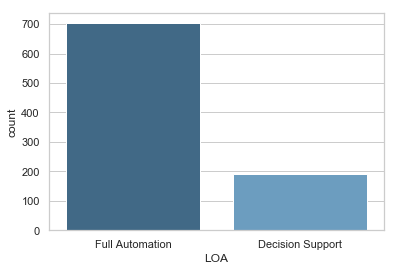

In [64]:
df = pd.DataFrame({'predicted': pred})
df['score']= df['predicted'].apply(lambda x: f1_dict[x])
df['LOA']=df['score'].apply(lambda x: 'Full Automation' if x >0.95 else 'Decision Support')
print(df)

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.countplot(x="LOA",data=df,  palette="Blues_d")

### Evaluating resource characteristic on unseen data
